In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [58]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal

from nf.flows import FCNN

import matplotlib.pyplot as plt
from IPython.display import clear_output
import xgboost as xgb

from copy import deepcopy

%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class NormalizingFlowModel(nn.Module):

    def __init__(self, dim, prior, flows):
        super().__init__()
        self.dim = dim
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m).to(x.device)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x)
        return z, prior_logprob, log_det

    def backward(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m).to(z.device)
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,self.dim))
        if z.dim() != 2: z = self.prior.sample((n_samples,))
        x, _ = self.backward(z)
        return x

In [5]:
class MAF(nn.Module):
    """
    Masked auto-regressive flow.

    [Papamakarios et al. 2018]
    """
    def __init__(self, dim, hidden_dim = 8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.initial_param = nn.Parameter(torch.Tensor(2))
        for i in range(1, dim):
            self.layers += [base_network(i, 2, hidden_dim)]
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.uniform_(self.initial_param, -np.sqrt(0.5), np.sqrt(0.5))

    def forward(self, x):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0]).to(x.device)
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](x[:, :i])
                mu, alpha = out[:, 0], out[:, 1]
            z[:, i] = (x[:, i] - mu) / torch.exp(alpha)
            log_det -= alpha
        return z.flip(dims=(1,)), log_det

    def backward(self, z):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.shape[0]).to(z.device)
        z = z.flip(dims=(1,))
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](x[:, :i])
                mu, alpha = out[:, 0], out[:, 1]
            x[:, i] = mu + torch.exp(alpha) * z[:, i]
            log_det += alpha
        return x, log_det

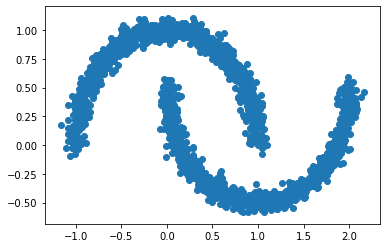

In [6]:
X, _ = make_moons(10000)
n, dim = X.shape
X += np.random.normal(0, 0.05, X.shape)
X = X.astype(np.float32)
X_train, X_test = X[: n * 2 // 10], X[n * 8 // 10: ]

plt.scatter(X_train[:, 0], X_train[:, 1])

In [7]:
X_train_tensor = torch.from_numpy(X_train).to(device)
X_test_tensor = torch.from_numpy(X_test).to(device)

In [8]:
prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))
model = NormalizingFlowModel(dim, prior, [MAF(dim), MAF(dim)]).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [9]:
epoches = 1000
metrics = []

### Учим обычный нф

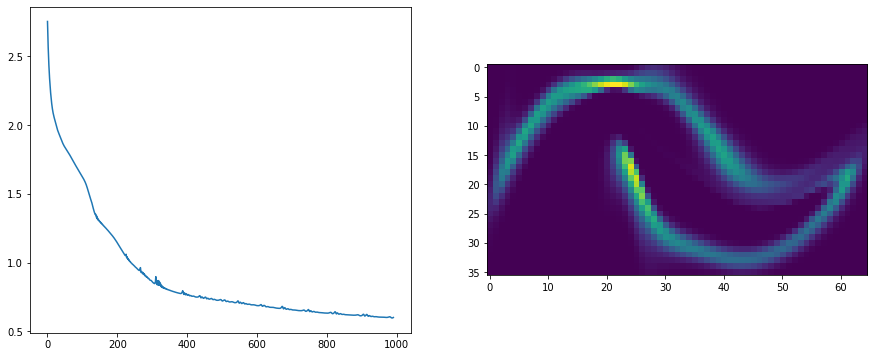

In [11]:
for epoch in range(len(metrics), epoches):
    model.train()
    optimizer.zero_grad()
    z, logp_z, log_det = model(X_train_tensor)
    logp_x = logp_z + log_det
    loss = -torch.mean(logp_x)
    loss.backward()
    optimizer.step()
    metrics.append(loss.mean().detach().cpu())

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            X_val = np.transpose(np.dstack(np.meshgrid(
                np.arange(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 0.05),
                np.arange(np.min(X_test[:, 1]), np.max(X_test[:, 1]), 0.05),
            )), axes=[1, 0, 2]).astype(np.float32)
            
            z, logp_z, log_det = model(
                torch.from_numpy(X_val.reshape(-1, 2)).to(device),
            )
            log_probs = logp_z + log_det
            log_probs = log_probs.detach().cpu().numpy()
            
        probs = np.exp(log_probs).reshape(X_val.shape[0], X_val.shape[1])

        clear_output(False)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        axs[0].plot(np.arange(len(metrics)), metrics)
        axs[1].imshow(probs.T[::-1])

    plt.show()

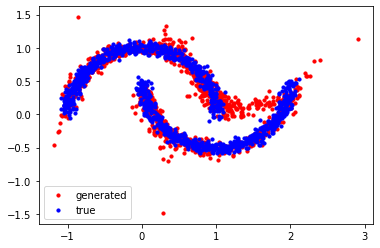

In [12]:
X_generated = model.sample(len(X_test)).detach().cpu().numpy()
y_generated = np.zeros(len(X_generated))
y_test = np.ones(len(X_test))

X_clf = np.vstack([X_test, X_generated])
y_clf = np.hstack([y_test, y_generated]).astype(int)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, shuffle=True, test_size=0.4)

plt.scatter(X_clf_train[y_clf_train==0][:, 0], X_clf_train[y_clf_train==0][:, 1], c='red', label='generated', s=10)
plt.scatter(X_clf_train[y_clf_train==1][:, 0], X_clf_train[y_clf_train==1][:, 1], c='blue', label='true', s=10)

plt.legend()

### Учим xgboost отличать сгенерированные данные от реальных

In [42]:
params = dict(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    min_child_weight=50,
    n_jobs=4,
    objective='binary:logitraw'
)
xgb_model = xgb.XGBClassifier(**params)

In [43]:
xgb_model.fit(
    X=X_clf_train,
    y=y_clf_train
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=None, n_estimators=200, n_jobs=4,
              nthread=None, objective='binary:logitraw', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [44]:
y_clf_pred_probas = xgb_model.predict_proba(X_clf_train)[:, 1]
roc_auc_score(y_clf_train, y_clf_pred_probas)

0.7308247894499621

In [45]:
y_clf_pred_probas = xgb_model.predict_proba(X_clf_test)[:, 1]
roc_auc_score(y_clf_test, y_clf_pred_probas)

0.6209614029275581

### Фиксим нф с помощью классификатора

In [46]:
class FixedModel:
    def __init__(self, clf, nf, logit=False):
        self.clf = clf
        self.nf = nf
        self.logit = logit

    def __call__(self, x):
        discr = self.clf.predict_proba(x)[:, 1] # clf(s)
        
        model.eval()
        with torch.no_grad():
            z, logp_z, log_det = model(
                torch.from_numpy(x).to(device)
            )
            log_probs = logp_z + log_det
            log_probs = log_probs.detach().cpu().numpy()

        if self.logit:
            return log_probs + discr
        else:
            return log_probs + np.log(discr) - np.log1p(-discr)

In [47]:
f_model = FixedModel(xgb_model, model, logit=True)

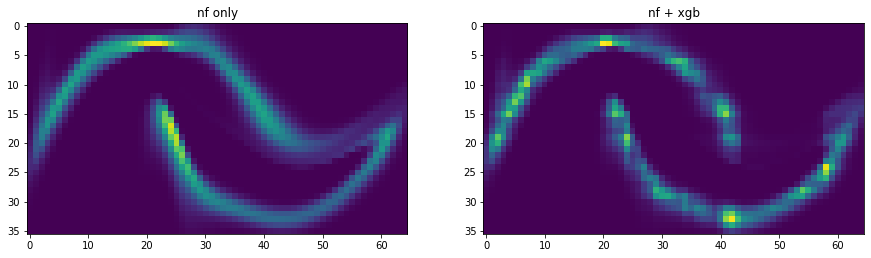

In [48]:
X_val = np.transpose(np.dstack(np.meshgrid(
    np.arange(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 0.05),
    np.arange(np.min(X_test[:, 1]), np.max(X_test[:, 1]), 0.05),
)), axes=[1, 0, 2]).astype(np.float32)

model.eval()
with torch.no_grad():
    z, logp_z, log_det = model(
        torch.from_numpy(X_val.reshape(-1, 2)).to(device),
    )
    log_probs = logp_z + log_det
    log_probs = log_probs.detach().cpu().numpy()

probs = np.exp(log_probs).reshape(X_val.shape[0], X_val.shape[1])

fixed_log_probs = f_model(X_val.reshape(-1, 2))
fixed_probs = np.exp(fixed_log_probs).reshape(X_val.shape[0], X_val.shape[1])

clear_output(False)
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].imshow(probs.T[::-1])
axs[0].set_title('nf only')
axs[1].imshow(fixed_probs.T[::-1])
axs[1].set_title('nf + xgb')

plt.show()

In [49]:
def importance_sampling(density, major_dist, c, n_samples):
    # p(x) / (c q(x))
    samples = major_dist.sample_n(n_samples)
    major_log_probs = unif.log_prob(samples).sum(1).detach().cpu().numpy()
    samples = samples.detach().cpu().numpy()

    log_probs = density(samples)

    accept_log_prob = log_probs - np.log(c) - major_log_probs

    is_accept = accept_log_prob > np.log(np.random.uniform(0, 1, n_samples))

    return samples[is_accept]

In [50]:
eps = 0.1
x1, x2, y1, y2 = np.min(X_test[:, 0]) - eps, np.max(X_test[:, 0]) + eps, np.min(X_test[:, 1]) - eps, np.max(X_test[:, 1]) + eps

In [51]:
unif = torch.distributions.Uniform(torch.FloatTensor([x1, y1]), torch.FloatTensor([x2, y2]))

In [52]:
c = int(np.max(fixed_probs) * (x2 - x1) * (y2 - y1) + 1)

In [53]:
samples = importance_sampling(f_model, unif, c, (c + 1) * 2000)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [54]:
samples.shape

(2251, 2)

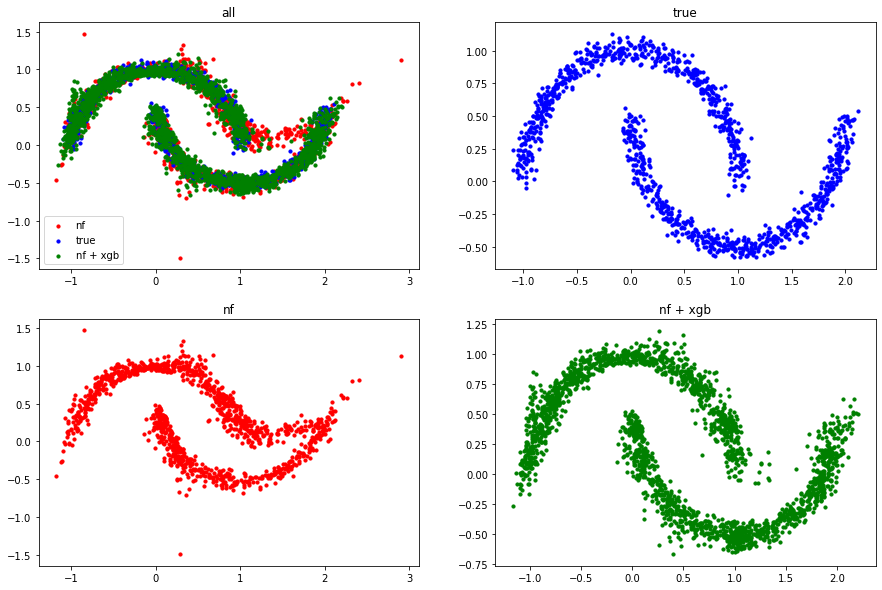

In [55]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].scatter(X_clf_train[y_clf_train==0][:, 0], X_clf_train[y_clf_train==0][:, 1], c='red', label='nf', s=10)
axs[0, 0].scatter(X_clf_train[y_clf_train==1][:, 0], X_clf_train[y_clf_train==1][:, 1], c='blue', label='true', s=10)
axs[0, 0].scatter(samples[:, 0], samples[:, 1], c='green', label='nf + xgb', s=10)
axs[0, 0].legend()
axs[0, 0].set_title('all')

axs[0, 1].scatter(X_clf_train[y_clf_train==1][:, 0], X_clf_train[y_clf_train==1][:, 1], c='blue', label='true', s=10)
axs[0, 1].set_title('true')

axs[1, 0].scatter(X_clf_train[y_clf_train==0][:, 0], X_clf_train[y_clf_train==0][:, 1], c='red', label='nf', s=10)
axs[1, 0].set_title('nf')

axs[1, 1].scatter(samples[:, 0], samples[:, 1], c='green', label='nf + xgb', s=10)
axs[1, 1].set_title('nf + xgb')

plt.show()

### А теперь попробуем доучить наш нф на kl дивергенцию с исправленной плотностью

In [111]:
metrics = []
epoches = 1000
batch_size = 10000
new_model = deepcopy(model)
new_optimizer = optim.Adam(new_model.parameters(), lr=0.002)

In [112]:
eps = 0.1
x1, x2, y1, y2 = np.min(X_train[:, 0]) - eps, np.max(X_train[:, 0]) + eps, np.min(X_train[:, 1]) - eps, np.max(X_train[:, 1]) + eps
unif = torch.distributions.Uniform(torch.FloatTensor([x1, y1]).to(device), torch.FloatTensor([x2, y2]).to(device))

In [113]:
def kl(log_p, log_q):
    return (log_p.exp() * (log_p - log_q)).sum()

In [114]:
def kl_sym(log_p, log_q):
    return 0.5 * (kl(log_p, log_q) + kl(log_q, log_p))

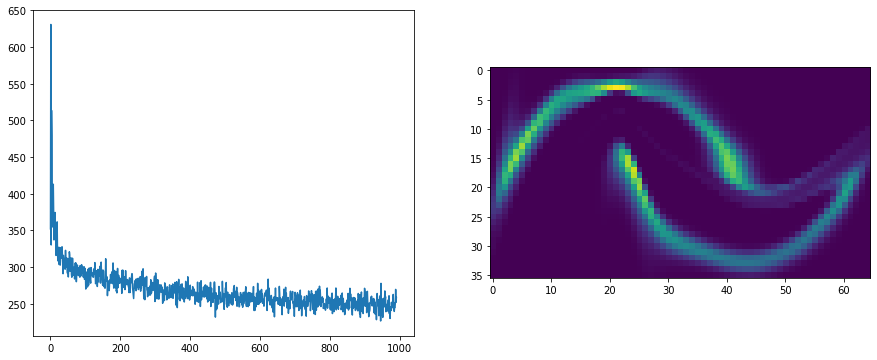

In [115]:
for epoch in range(len(metrics), epoches):
    train_batch = unif.sample((batch_size, ))
    true_log_probs = torch.from_numpy(f_model(train_batch.detach().cpu().numpy())).to(device)
    
    new_model.train()
    new_optimizer.zero_grad()
    z, logp_z, log_det = new_model(train_batch)
    logp_x = logp_z + log_det
    loss = kl_sym(logp_x, true_log_probs)
    loss.backward()
    new_optimizer.step()
    metrics.append(loss.mean().detach().cpu())

    if epoch % 10 == 0:
        new_model.eval()
        with torch.no_grad():
            X_val = np.transpose(np.dstack(np.meshgrid(
                np.arange(np.min(X_test[:, 0]), np.max(X_test[:, 0]), 0.05),
                np.arange(np.min(X_test[:, 1]), np.max(X_test[:, 1]), 0.05),
            )), axes=[1, 0, 2]).astype(np.float32)
            
            z, logp_z, log_det = new_model(
                torch.from_numpy(X_val.reshape(-1, 2)).to(device),
            )
            log_probs = logp_z + log_det
            log_probs = log_probs.detach().cpu().numpy()
            
        probs = np.exp(log_probs).reshape(X_val.shape[0], X_val.shape[1])

        clear_output(False)
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        axs[0].plot(np.arange(len(metrics)), metrics)
        axs[1].imshow(probs.T[::-1])

    plt.show()

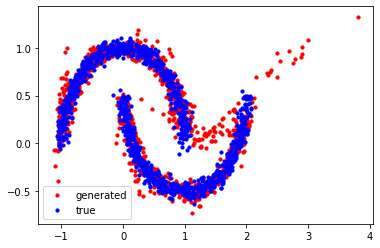

In [117]:
X_generated = new_model.sample(len(X_test)).detach().cpu().numpy()
y_generated = np.zeros(len(X_generated))
y_test = np.ones(len(X_test))

X_clf = np.vstack([X_test, X_generated])
y_clf = np.hstack([y_test, y_generated]).astype(int)

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y_clf, shuffle=True, test_size=0.4)

plt.scatter(X_clf_train[y_clf_train==0][:, 0], X_clf_train[y_clf_train==0][:, 1], c='red', label='generated', s=10)
plt.scatter(X_clf_train[y_clf_train==1][:, 0], X_clf_train[y_clf_train==1][:, 1], c='blue', label='true', s=10)

plt.legend()

In [118]:
new_xgb_model = xgb.XGBClassifier(**params)
new_xgb_model.fit(
    X=X_clf_train,
    y=y_clf_train
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=50, missing=None, n_estimators=200, n_jobs=4,
              nthread=None, objective='binary:logitraw', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [120]:
y_clf_pred_probas = new_xgb_model.predict_proba(X_clf_train)[:, 1]
roc_auc_score(y_clf_train, y_clf_pred_probas)

0.71540018018406

In [121]:
y_clf_pred_probas = new_xgb_model.predict_proba(X_clf_test)[:, 1]
roc_auc_score(y_clf_test, y_clf_pred_probas)

0.5712042261338035

### Выводы:
* Исправление нф классификатором работает хорошо, но надо уметь варить importance(или rejection, не помню какой из них что значит) sampling
* Доучивание на kl дивергенцию с правильным ответом работает хуже, визуально кажется что оно работает откровенно плохо, но метрики xgboost улучшает на тесте 0.62 -> 0.57 auc roc